In [2]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

C:\Users\Temnykov\AppData\Local\Temp\ipykernel_8156\2150022218.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
data = pd.read_csv('../../data/adult.csv')

data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [5]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


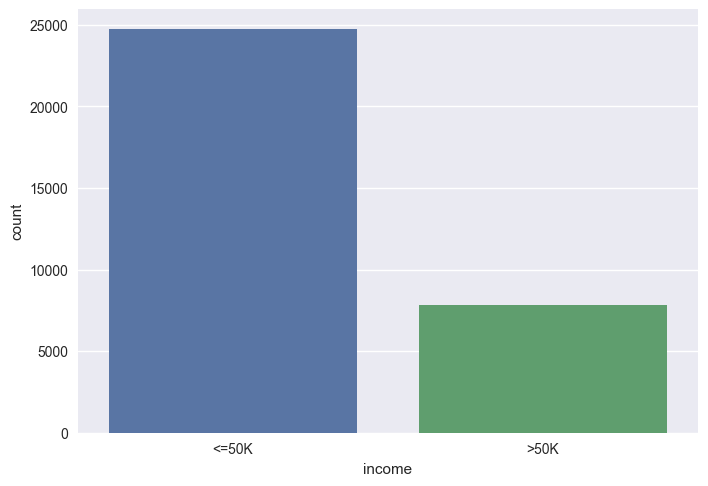

In [6]:
sns.countplot(data=data, x='income');

In [7]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [8]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

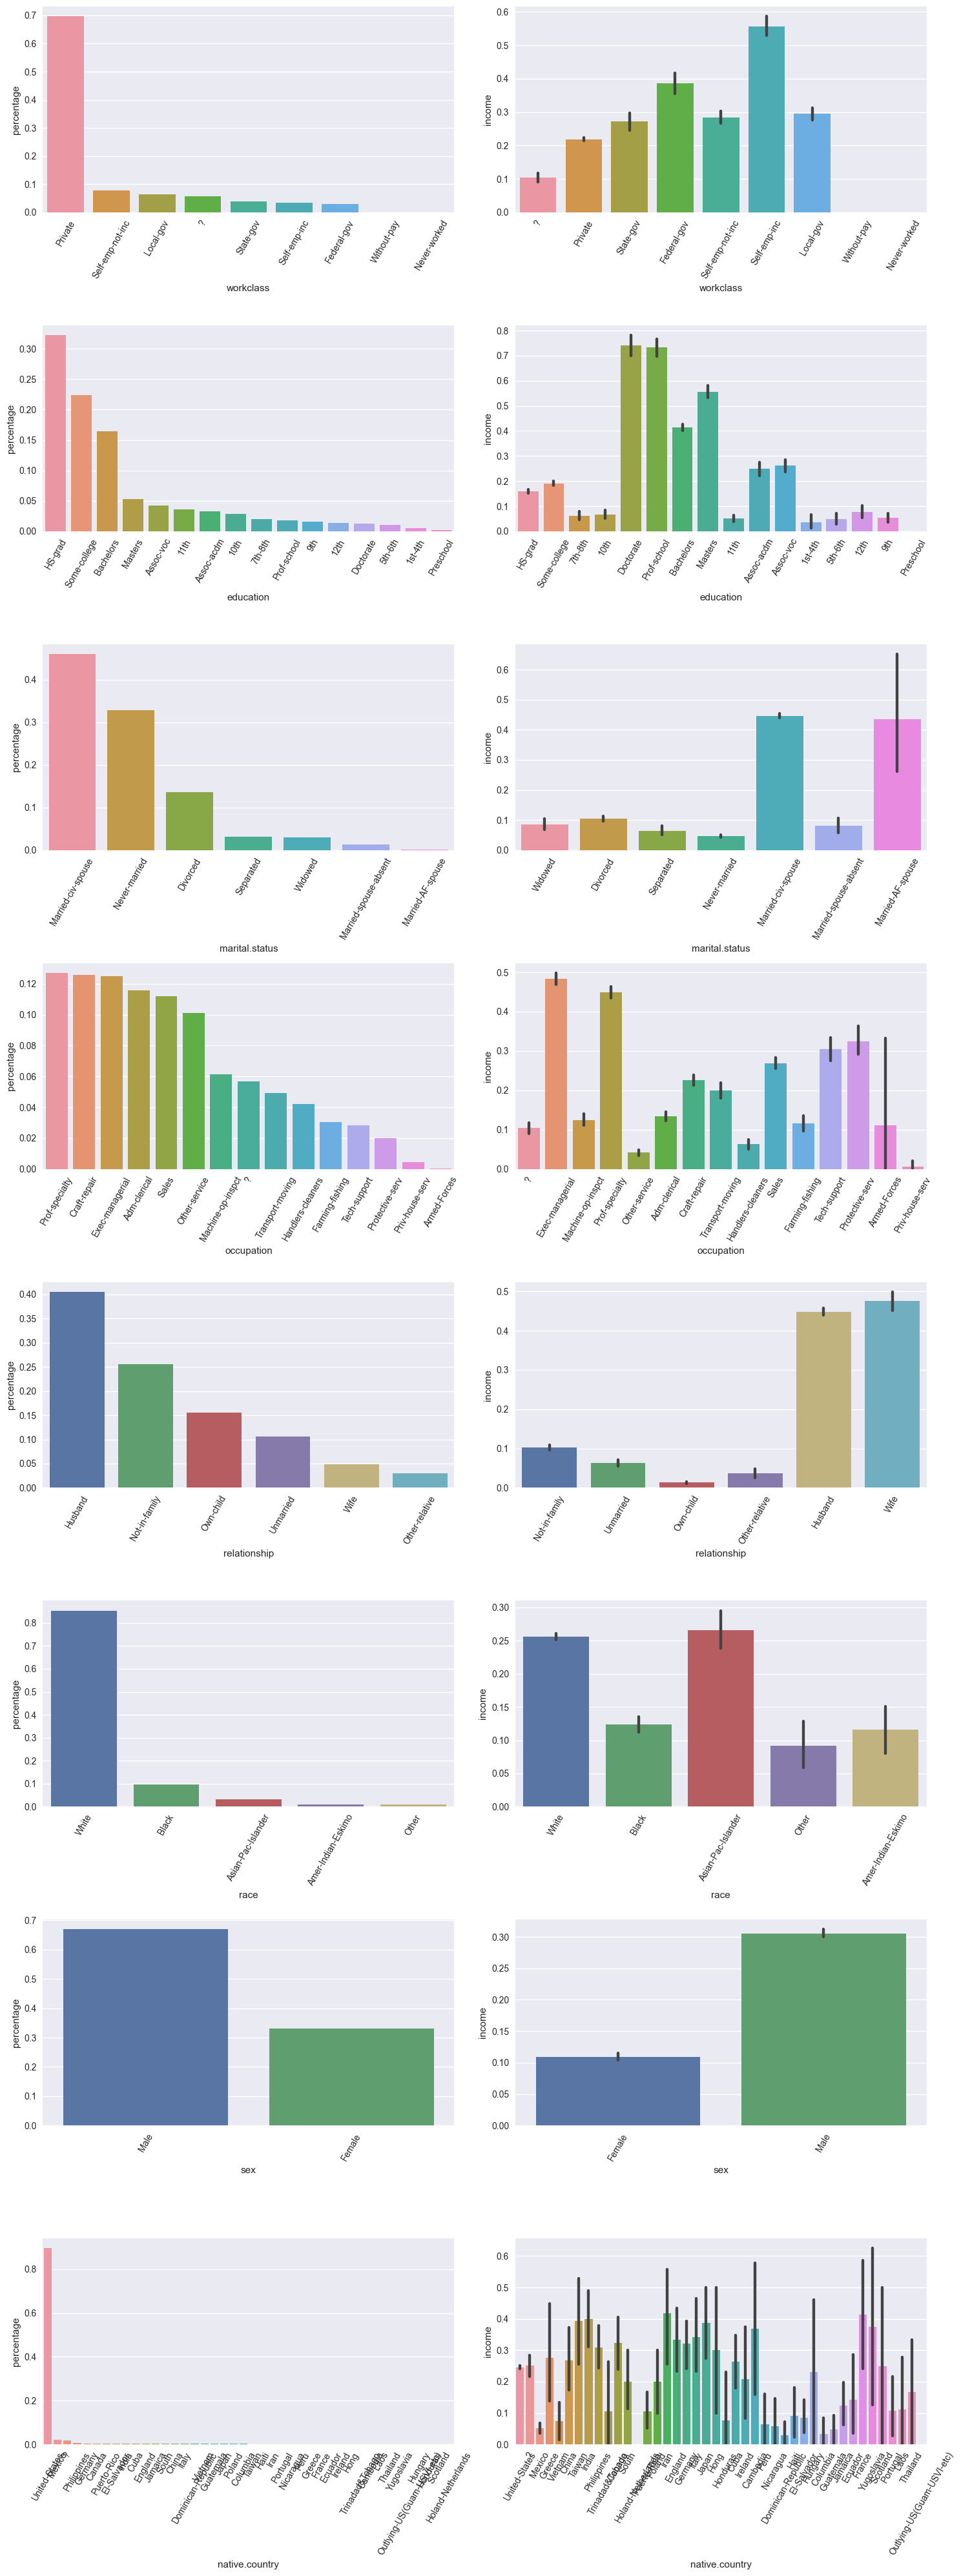

In [9]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

In [10]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

In [11]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [12]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

In [13]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


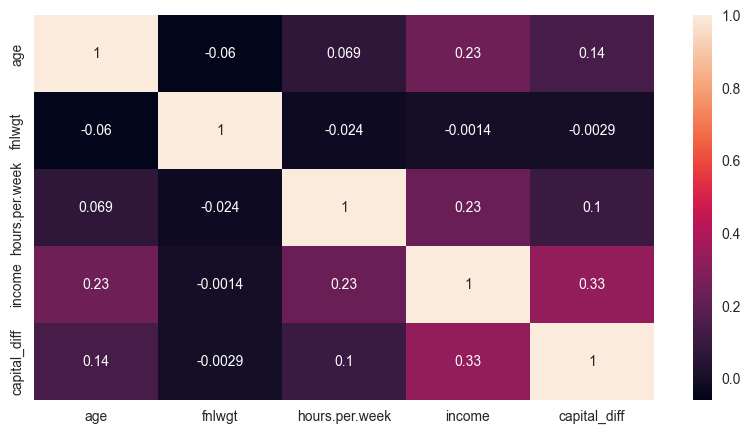

In [14]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(numeric_only=True), annot = True);

In [15]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
1,82,11.797134,18,0,8.379539,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
2,66,12.133835,40,0,8.379539,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,True
3,54,11.851966,40,0,8.268988,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
4,41,12.486216,40,0,8.268988,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True


In [16]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

In [18]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Задание 3.5
Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

+ n_estimators = от 100 до 300 включительно с шагом 10
+ min_samples_leaf = от 3 до 7 с шагом 1
+ max_depth = от 15 до 40 с шагом 1
+ Используйте Hyperopt с параметрами max_evals = 20.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

In [19]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


In [27]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [21]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [28]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
        #   rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [03:41<00:00, 11.09s/trial, best loss: -0.7639828998931244]
Наилучшие значения гиперпараметров {'max_depth': 30.0, 'min_samples_leaf': 3.0, 'n_estimators': 130.0}
CPU times: total: 3min 39s
Wall time: 3min 41s


In [29]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.76
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


### Задание 3.10
Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

+ n_estimators = от 100 до 300 включительно с шагом 10
+ min_samples_leaf = от 3 до 7 с шагом 1
+ max_depth = от 15 до 40 с шагом 1
+ Используйте Optuna с параметрами n_trails = 20.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

In [30]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 4.0.0


In [31]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 3, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [32]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-11-05 22:09:19,279] A new study created in memory with name: RandomForestClassifier
C:\Users\Temnykov\AppData\Local\Temp\ipykernel_8156\2807133578.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
C:\Users\Temnykov\AppData\Local\Temp\ipykernel_8156\2807133578.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
C:\Users\Temnykov\AppData\Local\Temp\ipykernel_8156\2807133578.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 3, 1)
[I 2024-11-05 22:09:38,644] Trial 0 finished with value: 0.7567664455995698 and parameters: {'n_estimators': 300, 'max_depth': 25, 'min_samples

CPU times: total: 4min 54s
Wall time: 4min 58s


In [33]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 240, 'max_depth': 40, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.77


In [34]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.87
f1_score на тестовом наборе: 0.68
